 ## BAF Veri Setinden GAN ile Yapa Veri Üretimi

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import time

C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('sample10.csv')  
data = pd.read_csv('sample10.csv') 

categorical_columns = ['income', 'customer_age', 'payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

# OneHotEncoder ile kategorik sütunları dönüştür
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))

# Encode edilmiş sütunları orijinal veri çerçevesine ekle
encoded_df.columns = encoder.get_feature_names_out(categorical_columns)

# Kategorik sütunları orijinal veri çerçevesinden çıkar
df = df.drop(columns=categorical_columns)

# Yeni encode edilmiş sütunları ekle
df = pd.concat([df, encoded_df], axis=1)

# 'fraud_bool' sütununu sakla
fraud_bool = df['fraud_bool']

# Diğer sütunları ölçekle
columns_to_scale = df.columns.difference(['fraud_bool'])
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# 'fraud_bool' sütununu tekrar ekle
scaled_df['fraud_bool'] = fraud_bool



In [ ]:
scaled_df['fraud_bool']

In [3]:
latent_dim = 100
num_epochs = 20
batch_size = 64

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Daha fazla nöron
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),  # Daha derin bir model için katman ekleme
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Daha geniş bir katman
            nn.ReLU(),  # ReLU kullanımı
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(input_dim=latent_dim, output_dim=scaled_df.shape[1]).to(device)
discriminator = Discriminator(input_dim=scaled_df.shape[1]).to(device)

# Optimizasyon parametrelerini düzenleme
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.BCELoss()

data_tensor = torch.tensor(scaled_df.values, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def train_model():
    start_time = time.time()
    for epoch in range(num_epochs):
        for real_data in train_loader:
            real_data = real_data[0]

            batch_size = real_data.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            optimizer_d.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')
    
    end_time = time.time()
    return end_time - start_time

if device.type == 'cuda':
    gpu_time = train_model()
    print(f"GPU eğitim süresi: {gpu_time:.2f} saniye")
else:
    cpu_time = train_model()
    print(f"CPU eğitim süresi: {cpu_time:.2f} saniye")



Epoch [1/20] | D Loss: 1.1165001094341278 | G Loss: 0.9007402658462524
Epoch [2/20] | D Loss: 0.11966872960329056 | G Loss: 3.063427209854126
Epoch [3/20] | D Loss: 0.1084715761244297 | G Loss: 3.377577066421509
Epoch [4/20] | D Loss: 0.39772820472717285 | G Loss: 2.7526888847351074
Epoch [5/20] | D Loss: 0.3601035326719284 | G Loss: 3.225379228591919
Epoch [6/20] | D Loss: 0.2846626155078411 | G Loss: 3.835430145263672
Epoch [7/20] | D Loss: 0.06863235495984554 | G Loss: 4.5266923904418945
Epoch [8/20] | D Loss: 0.2686203271150589 | G Loss: 3.5944442749023438
Epoch [9/20] | D Loss: 0.21329760551452637 | G Loss: 3.6766486167907715
Epoch [10/20] | D Loss: 0.35970906913280487 | G Loss: 3.472465991973877
Epoch [11/20] | D Loss: 1.1184934079647064 | G Loss: 2.9213225841522217
Epoch [12/20] | D Loss: 0.03490799991413951 | G Loss: 4.479560852050781
Epoch [13/20] | D Loss: 0.002547155469073914 | G Loss: 6.102591037750244
Epoch [14/20] | D Loss: 0.003840274643152952 | G Loss: 6.45034313201904

In [4]:
num_samples = 10000
noise = torch.randn(num_samples, latent_dim)

generated_data = generator(noise).detach().numpy()

generated_df = pd.DataFrame(generated_data, columns=scaled_df.columns)

generated_df[columns_to_scale] = scaler.inverse_transform(generated_df[columns_to_scale])

categorical_output = pd.DataFrame(encoder.inverse_transform(generated_df[encoded_df.columns]))
categorical_output.columns = categorical_columns

generated_df = generated_df.drop(columns=encoded_df.columns)
generated_df = pd.concat([generated_df, categorical_output], axis=1)

In [5]:
generated_df.head()

,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,income,customer_age,payment_type,employment_status,housing_status,source,device_os,device_distinct_emails_8w,device_fraud_count,month
0,0.202342,-27.220648,172.086548,-4.50484,-11.382098,2575.304932,8679.772461,6247.45752,5764.664062,641.316345,...,0.8,30,AE,CB,BB,TELEAPP,other,1,0,2
1,0.202342,-27.220648,172.086517,-4.50484,-11.382113,2575.304932,8679.772461,6247.45752,5764.664062,641.316345,...,0.8,30,AE,CB,BB,TELEAPP,other,1,0,2
2,0.202342,-27.220648,172.086548,-4.50484,-11.380204,2575.304932,8679.772461,6247.45752,5764.664062,641.316345,...,0.8,30,AE,CB,BB,TELEAPP,other,1,0,2
3,0.202342,-27.220648,172.086548,-4.50484,-11.382113,2575.304932,8679.772461,6247.45752,5764.664062,641.316345,...,0.8,30,AE,CB,BB,TELEAPP,other,1,0,2
4,0.202342,-27.220648,172.086548,-4.50484,-11.381867,2575.304932,8679.772461,6247.45752,5764.664062,641.316345,...,0.8,30,AE,CB,BB,TELEAPP,other,1,0,2


In [6]:
generated_df["fraud_bool"] = generated_df["fraud_bool"].astype(int)


In [7]:
generated_df["fraud_bool"].value_counts()

fraud_bool
1    7774
0    2226
Name: count, dtype: int64

In [8]:
"""

df_sorted = generated_df.sort_values(by='fraud_bool', ascending=False).reset_index()

df_sorted.loc[:99, 'fraud_bool'] = 1  
df_sorted.loc[100:, 'fraud_bool'] = 0  

generated_df['fraud_bool'] = df_sorted.sort_values(by='index').reset_index(drop=True)['fraud_bool']
"""

"\n\ndf_sorted = generated_df.sort_values(by='fraud_bool', ascending=False).reset_index()\n\ndf_sorted.loc[:99, 'fraud_bool'] = 1  \ndf_sorted.loc[100:, 'fraud_bool'] = 0  \n\ngenerated_df['fraud_bool'] = df_sorted.sort_values(by='index').reset_index(drop=True)['fraud_bool']\n"

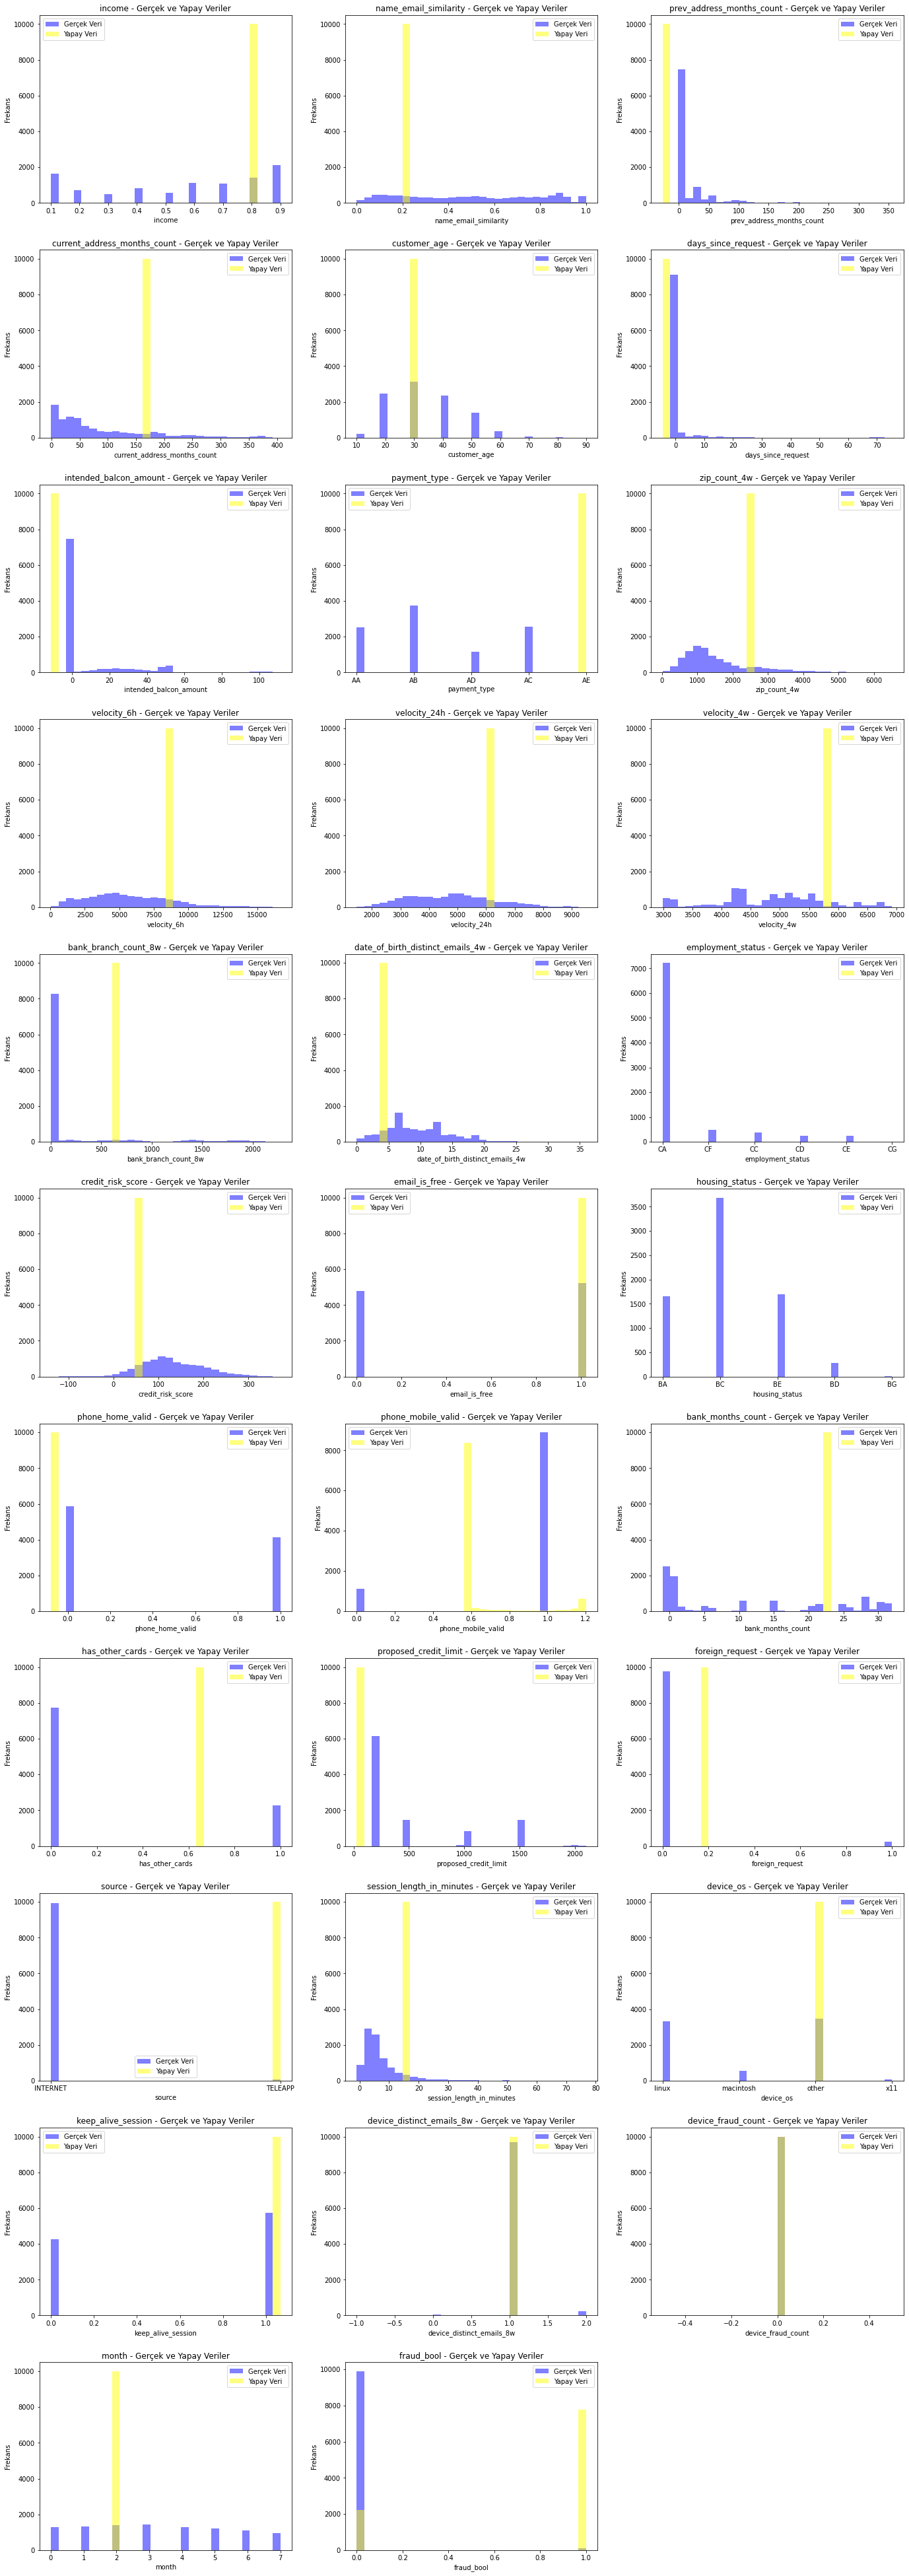

In [9]:
df = data

features = df.columns

num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  

for i, feature in enumerate(features):
    row = i // num_columns
    col = i % num_columns
    
    ax = axes[row, col]
    
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    ax.hist(df[feature], bins=30, alpha=0.5, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    ax.hist(generated_df[feature], bins=30, alpha=0.5, label='Yapay Veri', color='yellow', range=(min_val, max_val))
    
    ax.set_title(f'{feature} - Gerçek ve Yapay Veriler')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frekans')
    ax.legend()

for j in range(len(features), num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.show()